# Model Evaluation & Explaination

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

from src.__00__paths import figures_dir, model_dir, docs_dir, curated_data_dir

## Load Model

In [2]:
try:
    best_rf = joblib.load(model_dir / "random_forest_model.joblib")
except FileNotFoundError:
    print("Model not found. Please run 02_model_training.ipynb first.")
    exit()

## Load Data

In [3]:
test_df = pd.read_csv(curated_data_dir / "test.csv")
test_df.head()

,Type,Size,Dept,IsHoliday,time_index,woy_sin,woy_cos,mon_sin,mon_cos,week_of_month,...,dist_easter_wk,dist_memorial_day_wk,dist_july4_wk,dist_labor_day_wk,dist_super_bowl_wk,is_black_friday_wk,is_thanksgiving_wk,is_xmas_peak_wk,is_back_to_school,Weekly_Sales
0,B,125833,17,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,4202.98
1,A,184109,41,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,307.50
2,A,203750,3,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,7245.43
3,C,39910,23,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,23.01
4,B,140167,4,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,19455.41


## Declare Features & Labels

In [4]:
x_test = test_df.drop(columns=["Weekly_Sales"])
y_test = test_df["Weekly_Sales"]

# One-hot encode both sets
x_test = pd.get_dummies(x_test, columns=["Type"], prefix="Type")

## Model Predictions

In [5]:
y_pred = best_rf.predict(x_test)

## Evaluation

In [6]:
mae = mean_absolute_error(y_test, y_pred)
avg_sales = y_test.mean()
relative_error = mae / avg_sales * 100

# Holiday weights: 5 for holidays, 1 otherwise
weights = test_df["IsHoliday"].apply(lambda x: 5 if x else 1)
wmae = (weights * abs(y_test - y_pred)).sum() / weights.sum()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred) * 100

# Print results
print(f"MAE: {mae:.2f}")
print(f"Average Weekly Sales: ${avg_sales:.2f}")
print(f"Relative MAE: {relative_error:.2f}%")
print(f"WMAE: {wmae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}%")

MAE: 3259.23
Average Weekly Sales: $15785.37
Relative MAE: 20.65%
WMAE: 3264.11
RMSE: 5432.70
R² Score: 93.88%


## Save Text File

In [7]:
# File path for metrics
metrics_file = docs_dir / "RF_model_metrics.txt"

# Write metrics
with open(metrics_file, "w") as f:
    f.write(f"MAE: {mae:.2f}\n")
    f.write(f"Average Weekly Sales: ${avg_sales:.2f}\n")
    f.write(f"Relative MAE: {relative_error:.2f}%\n")
    f.write(f"WMAE: {wmae:.2f}\n")
    f.write(f"RMSE: {rmse:.2f}\n")
    f.write(f"R² Score: {r2:.4f}\n")

print(f"Evaluation metrics saved to: {'/'.join(metrics_file.parts[-3:])}")

Evaluation metrics saved to: outputs/docs/RF_model_metrics.txt


## Visualization

### Actual Vs Prediction

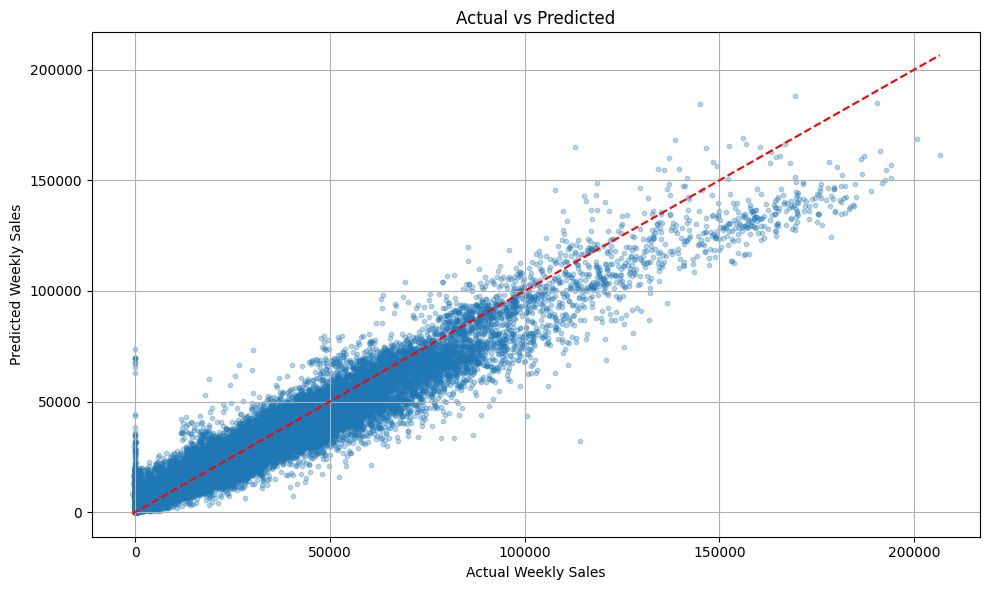

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig(figures_dir / "RF_actual_predicted.png", dpi=300)

plt.show()

### Residual Distribution

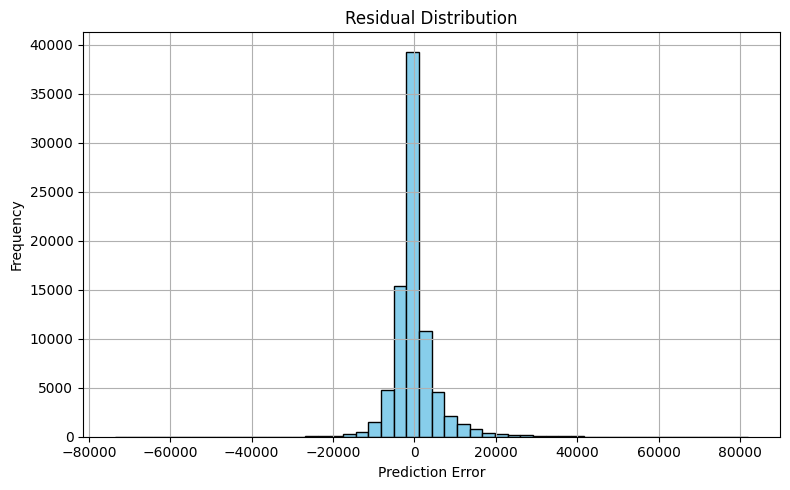

In [9]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, color="skyblue", edgecolor="black")
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig(figures_dir / "RF_residual_hist.png", dpi=300)
plt.show()

### Residuals vs Predicted

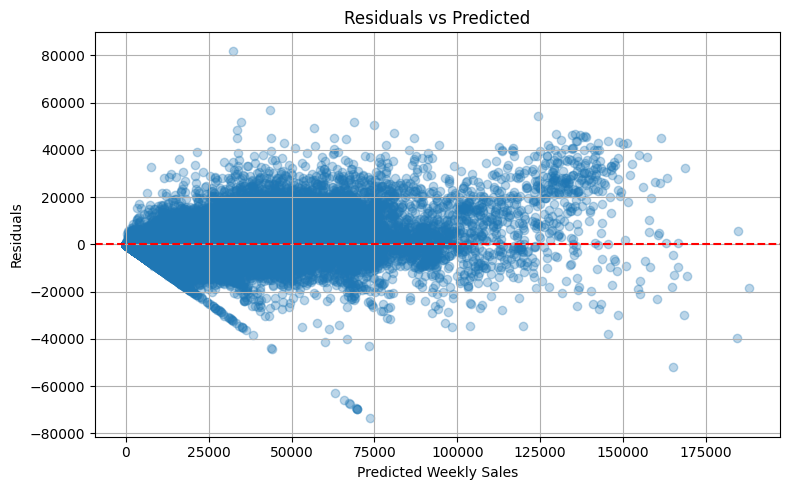

In [10]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Weekly Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.savefig(figures_dir / "RF_residuals_vs_pred.png", dpi=300)
plt.show()